In [1]:
import scvi
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import vstack, csr_matrix

/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
condition_key = 'embryo_id'
label_key = 'cellcluster_moscot'
adata_path = f'/home/icb/jonas.flor/gastrulation_atlas/scvi/training/10k/2k_genes'
metrics_path = f'/home/icb/jonas.flor/gastrulation_atlas/scvi/training/10k/2k_genes/metrics'
n_obs=10000

In [3]:
adata = sc.read_h5ad(f'/lustre/groups/ml01/workspace/monge_velo/data/mouse_gastrulation_atlas/training/adata_10k.h5ad')
neighbors = adata.uns['neighbors']
obsp = adata.obsp

In [4]:
adata_copy = adata.copy()
sc.pp.normalize_total(adata_copy)
sc.pp.log1p(adata_copy)
sc.pp.highly_variable_genes(
    adata_copy,
    n_top_genes=2000,
    batch_key=condition_key,
)
highly_variable = adata_copy.var["highly_variable"]
del adata_copy

In [5]:
adata = ad.concat([
    sc.read_h5ad('/lustre/groups/ml01/workspace/monge_velo/data/mouse_gastrulation_atlas/training/validation.h5ad'),
    adata
])
adata._inplace_subset_var(highly_variable)

In [6]:
var = adata.var #otherwise not subsetted to hgv genes

scvi.model.SCVI.setup_anndata(adata, batch_key=condition_key)
vae = scvi.model.SCVI(
    adata,
    n_layers=2,#n_layers=10,
    n_hidden=64,#n_hidden=1024,
    n_latent=50,
    use_layer_norm="both",
    use_batch_norm="none"
)
vae.train(check_val_every_n_epoch=1, max_epochs=500, early_stopping=True, train_size=n_obs/adata.n_obs, validation_size=None, shuffle_set_split=False)
vae.save(adata_path, overwrite=True)

I0000 00:00:1698755531.149824 3944779 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/jonas.flor/mambaforge/envs/scvi/lib/python ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/jonas.flor/mambaforge/envs/

Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [28:38<00:00,  3.34s/it, v_num=1, train_loss_step=795, train_loss_epoch=848]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [28:38<00:00,  3.44s/it, v_num=1, train_loss_step=795, train_loss_epoch=848]


In [7]:
adata_unint = adata[100000:]
adata_unint.var = var
adata_unint.uns['neighbors'] = neighbors
adata_unint.obsp = obsp

<Axes: >

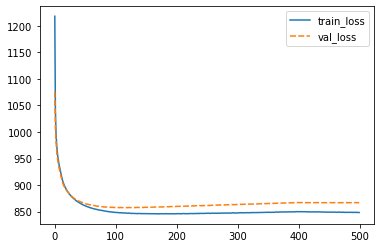

In [8]:
import seaborn as sns
sns.lineplot(
pd.DataFrame(
    np.concatenate([vae.history['train_loss_epoch'], vae.history['validation_loss']], axis=1), columns=['train_loss', 'val_loss']
))
#sns.lineplot(pd.DataFrame(
#    np.concatenate([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1), columns=['train_elbo', 'val_elbo']
#))
#sns.lineplot(pd.DataFrame(
#    np.concatenate([vae.history['reconstruction_loss_train'], vae.history['reconstruction_loss_validation']], axis=1), columns=['train_recon_loss', 'val_recon_loss']
#))

# End of Training

In [9]:
adata_path = f'/home/icb/jonas.flor/gastrulation_atlas/scvi/training/10k/2k_genes'
step = 1000
vae_loaded = scvi.model.SCVI.load(dir_path=adata_path, adata=adata_unint)

INFO     File /home/icb/jonas.flor/gastrulation_atlas/scvi/training/10k/2k_genes/model.pt already downloaded       


/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/jonas.flor/mambaforge/envs/scvi/lib/python ...
  rank_zero_warn(


In [25]:
vae_loaded.posterior_predictive_sample().to_scipy_sparse().data

array([1., 1., 1., ..., 1., 4., 8.], dtype=float32)

In [16]:
adata_int = ad.AnnData(vae_loaded.posterior_predictive_sample().to_scipy_sparse())

In [18]:
adata_int.obs = adata.obs[100000:]
adata_int.var = adata.var

In [19]:
adata_int.obsm["X_emb"] = vae_loaded.get_latent_representation()

/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


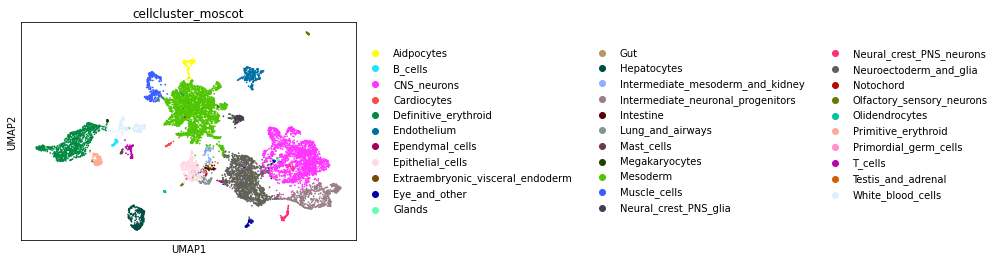

In [21]:
sc.pp.neighbors(adata_int, use_rep='X_emb')
sc.tl.umap(adata_int)
sc.pl.umap(adata_int, color=label_key)

/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


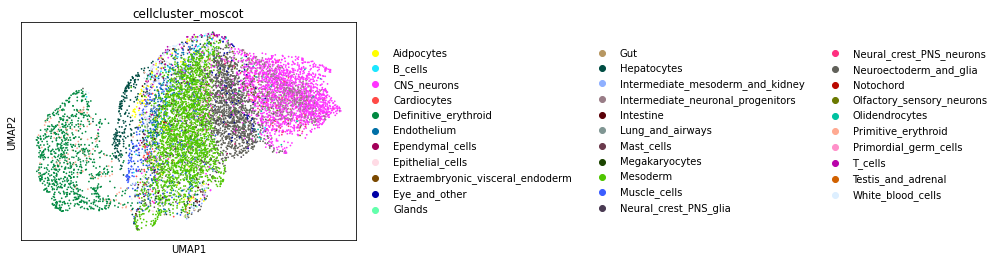

In [22]:
sc.pp.pca(adata_int)
sc.pp.neighbors(adata_int, use_rep='X_pca')
sc.tl.umap(adata_int)
sc.pl.umap(adata_int, color=label_key)

/home/icb/jonas.flor/mambaforge/envs/scvi/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


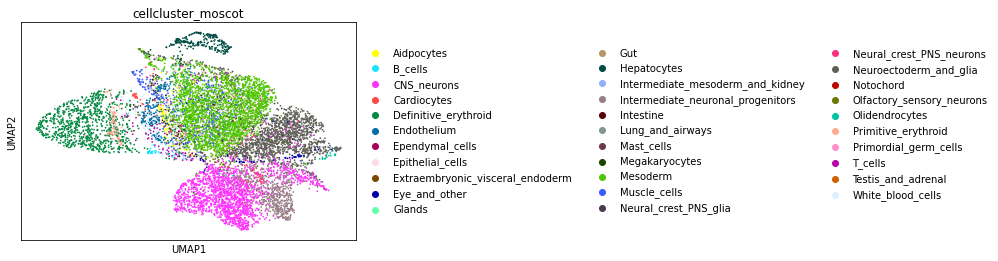

In [95]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=label_key)

In [103]:
adata._inplace_subset_var(highly_variable)